In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns

pd.set_option('display.precision', 3)
pd.set_option('max_rows', 150)
pd.set_option('max_info_rows', 150)
pd.set_option('max_info_columns', 150)

In [2]:
train_csv = pd.read_csv('../input/application_train.csv.zip', compression='infer', index_col='SK_ID_CURR')
infer_csv = pd.read_csv('../input/application_test.csv.zip', compression='infer', index_col='SK_ID_CURR')

In [3]:
def delete_rows(df):
    # removing 4 rows
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # removing 2 rows
    df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']
        
    return df

In [4]:
def drop_columns(df):
    columns_to_drop = [
        'FLAG_DOCUMENT_2',  # only 15 people provided this document and 4 are approved (nothing to learn from this feature)
        'FLAG_DOCUMENT_4',  # only 25 people provided this document and all are approved (high bias toward 1)
        'FLAG_DOCUMENT_7',  # only 59 people provided this document and 3 are approved (high bias towards 0)
        'FLAG_DOCUMENT_10', # only 7 people provided this document and None are approved (high bias towards 0)
        'FLAG_DOCUMENT_12', # only 2 people provided this document and None are approved (high bias towards 0)
        'FLAG_DOCUMENT_17', # only 82 people provided this document and 2 are approved (high bias towards 0)
        'FLAG_MOBIL',       # only 1 didn't provide this info and he is rejected (high bias towards 0)
    ]
    
    # removing all columns which contain AVG, MEDI and MODE in their names
    for column in df.columns:
        words = column.split('_')
        if (words[-1].lower() == 'avg') or (words[-1].lower() == 'medi') or (words[-1].lower() == 'mode'):
            columns_to_drop.append(column)
    
    # performing the drop
    df.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
def transform_bureau_data(index):
    '''
    Generates the following features for each applicant:
    
    Input:
    df - bureau dataset
    index - applicants on which we want to subset the bureau dataset (trainig, validation, testing)
    
    Output: 
    dataframe with all new features and index 'SK_ID_CURR'
    
    CNT_ACTIVE_LOANS  - number of active loans with other institutions
    CNT_BAD_LOANS     - number of bad loans with other institutions
    CNT_CLOSED_LOANS  - number of closed loans with other institutions
    CNT_SOLD_LOANS    - number of loans sold by the other institutions
    
    AMT_ACTIVE_LOANS  - total outstanding loans amount with other istitutions
    AMT_BAD_LOANS     - total bad loans amount with other institutions
    AMT_CLOSED_LOANS  - total amount of closed loans with other institutions
    AMT_SOLD_LOANS    - total amount of sold loans with other institutions
    
    DAYS_OUTSTANDING  - days due of the loan which ends last
    DAYS_RECENT_CLOSE - days since the applicant closed his most recent loan
    
    AMT_OUTSTD_0_YEAR - outstanding amount due less than a year
    AMT_OUTSTD_1_YEAR - outstanding amount due within [1, 2) years
    AMT_OUTSTD_2_YEAR - outstanding amount due within [2, 3) years
    AMT_OUTSTD_3_YEAR - outstanding amount due within [3, 4) years
    AMT_OUTSTD_4_YEAR - outstanding amount due within [4, 5) years
    AMT_OUTSTD_5_YEAR - outstanding amount due within [5, inf) years
    
    CNT_PROLONGED     - total number of prolongations for active credits
    '''
    def column_labels_bureau():
        '''
        Creates nested dictionaries used for renaming the dfs' column names
        '''
        labels = {}

        labels['num_credits'] = {
              'Active'   : 'CNT_ACTIVE_LOANS',
              'Bad debt' : 'CNT_BAD_LOANS',
              'Closed'   : 'CNT_CLOSED_LOANS',
              'Sold'     : 'CNT_SOLD_LOANS'
             }

        labels['amt_credits'] = {
              'Active'   : 'AMT_ACTIVE_LOANS',
              'Bad debt' : 'AMT_BAD_LOANS',
              'Closed'   : 'AMT_CLOSED_LOANS',
              'Sold'     : 'AMT_SOLD_LOANS'
             }

        labels['max_days_active'] = {
              'Active'   : 'DAYS_OUTSTANDING',
              'Bad debt' : 'DROP_1',
              'Closed'   : 'DROP_2',
              'Sold'     : 'DROP_3'
             }

        labels['max_days_closed'] = {
              'Active'   : 'DROP_4',
              'Bad debt' : 'DROP_5',
              'Closed'   : 'DAYS_RECENT_CLOSE',
              'Sold'     : 'DROP_6'
             }

        labels['cnt_prolonged'] = {
              'Active'   : 'CNT_PROLONGED',
              'Bad debt' : 'DROP_7',
              'Closed'   : 'DROP_8',
              'Sold'     : 'DROP_9'
             }
        
        labels['amt_active_overdue'] = {
            'Active'   : 'AMT_ACTIVE_OVERDUE',
            'Bad debt' : 'DROP_10',
            'Closed'   : 'DROP_11',
            'Sold'     : 'DROP_12'
        }
        
        labels['max_days_overdue'] = {
            'Active'   : 'DAYS_ACTIVE_OVERDUE',
            'Bad debt' : 'DROP_13',
            'Closed'   : 'DROP_14',
            'Sold'     : 'DROP_15'
        }

        return labels
    
    df = pd.read_csv('../input/bureau.csv.zip', compression='infer')
    
    # taking a subset of the bureau dataset
    df = df.loc[index,:]
    
    num_credits = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='CREDIT_ACTIVE', 
            values='SK_ID_BUREAU', 
            aggfunc='count', 
            fill_value=0
        ).to_records()
    )
    
    amt_credits = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='CREDIT_ACTIVE', 
            values='AMT_CREDIT_SUM_DEBT', 
            aggfunc='sum', 
            fill_value=0
        ).to_records()
    )
    
    max_days_active = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='CREDIT_ACTIVE', 
            values='DAYS_CREDIT_ENDDATE', 
            aggfunc='max', 
            fill_value=0
        ).to_records()
    )
    
    max_days_closed = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='CREDIT_ACTIVE', 
            values='DAYS_ENDDATE_FACT', 
            aggfunc='max', 
            fill_value=0
        ).to_records()
    )
    
    cnt_prolonged = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='CREDIT_ACTIVE', 
            values='CNT_CREDIT_PROLONG', 
            aggfunc='sum',
            fill_value=0
        ).to_records()
    )
    
    amt_active_overdue = pd.DataFrame(
        df.pivot_table(
        index='SK_ID_CURR', 
        columns='CREDIT_ACTIVE', 
        values='AMT_CREDIT_SUM_OVERDUE', 
        aggfunc='sum',
        fill_value=0
        ).to_records()
    )
    
    max_days_overdue = pd.DataFrame(
        df.pivot_table(
        index='SK_ID_CURR', 
        columns='CREDIT_ACTIVE', 
        values='CREDIT_DAY_OVERDUE', 
        aggfunc='max',
        fill_value=0
        ).to_records()
    )
    
    # credit amounts due for the next 5+ years
    df.loc[:,'YEARS_ENDDATE'] = df.loc[:,'DAYS_CREDIT_ENDDATE']//365
    df['YEARS_ENDDATE'].fillna(0,inplace=True)
    df['YEARS_ENDDATE'].clip(lower=0, upper=5,inplace=True)
    
    amt_credits_by_year = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns=['CREDIT_ACTIVE','YEARS_ENDDATE'], 
            values='AMT_CREDIT_SUM_DEBT', 
            aggfunc='sum', 
            fill_value=0
        ).to_records()
    )
    amt_credits_by_year.set_index('SK_ID_CURR', inplace=True)
    columns = amt_credits_by_year.columns[:6]
    amt_credits_by_year = amt_credits_by_year[columns] # take only the first 6 columns the rest is garbage
    del columns  
    
    # number of credits in the past year
    df.loc[:,'YEARS_OPEN_DATE'] = df.loc[:,'DAYS_CREDIT']//365
    df['YEARS_OPEN_DATE'].fillna(0,inplace=True)
    df['YEARS_OPEN_DATE'].clip(lower=-5, upper=0,inplace=True)
    
    num_active_credits_past_years = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns=['CREDIT_ACTIVE','YEARS_OPEN_DATE'], 
            values='SK_ID_BUREAU', 
            aggfunc='count', 
            fill_value=0
        ).to_records()
    )
    num_active_credits_past_years.set_index('SK_ID_CURR', inplace=True)
    columns = num_active_credits_past_years.columns[:6]
    num_active_credits_past_years = num_active_credits_past_years[columns] # take only the first 6 columns the rest is garbage
    del columns
    
    num_credits.set_index('SK_ID_CURR', inplace=True)
    amt_credits.set_index('SK_ID_CURR', inplace=True)
    max_days_active.set_index('SK_ID_CURR', inplace=True)
    max_days_closed.set_index('SK_ID_CURR', inplace=True)
    cnt_prolonged.set_index('SK_ID_CURR', inplace=True)
    amt_active_overdue.set_index('SK_ID_CURR', inplace=True)
    max_days_overdue.set_index('SK_ID_CURR', inplace=True)

    labels = column_labels_bureau()
    
    num_credits.rename(columns=labels['num_credits'], inplace=True)
    amt_credits.rename(columns=labels['amt_credits'], inplace=True)
    max_days_active.rename(columns=labels['max_days_active'], inplace=True)
    max_days_closed.rename(columns=labels['max_days_closed'], inplace=True)
    cnt_prolonged.rename(columns=labels['cnt_prolonged'], inplace=True)
    amt_active_overdue.rename(columns=labels['amt_active_overdue'], inplace=True)
    max_days_overdue.rename(columns=labels['max_days_overdue'], inplace=True)
        
    amt_credits_by_year.columns = [
        'AMT_OUTSTD_0_YEAR', 
        'AMT_OUTSTD_1_YEAR', 
        'AMT_OUTSTD_2_YEAR', 
        'AMT_OUTSTD_3_YEAR',
        'AMT_OUTSTD_4_YEAR',
        'AMT_OUTSTD_5_YEAR'
    ]
    
    num_active_credits_past_years.columns = [
        'CNT_ACT_LOANS_OPEN_5_YEAR',
        'CNT_ACT_LOANS_OPEN_4_YEAR',
        'CNT_ACT_LOANS_OPEN_3_YEAR',
        'CNT_ACT_LOANS_OPEN_2_YEAR',
        'CNT_ACT_LOANS_OPEN_1_YEAR',
        'CNT_ACT_LOANS_OPEN_0_YEAR',
    ]
    
    transformed = pd.DataFrame(index=num_credits.index)
    
    transformed = transformed.join(
        [
            num_credits,
            amt_credits,
            max_days_active,
            max_days_closed,
            amt_credits_by_year,
            cnt_prolonged,
            num_active_credits_past_years,
            amt_active_overdue,
            max_days_overdue
        ]
    )

    columns_to_drop = []
    
    for column in transformed:
        words = column.split('_')
        if words[0] == 'DROP':
            columns_to_drop.append(column)
            
    transformed.drop(columns_to_drop, inplace=True, axis=1)
    
    del df
    
    return transformed

In [6]:
def transform_prev_data(index):
    '''
    
    '''
    def column_labels_prev():
        '''
        Creates nested dictionaries used for renaming the dfs' column names
        '''
        labels = {}

        labels['num_credits'] = {
              'Approved'     : 'CNT_APPROVED_LOANS',
              'Canceled'     : 'CNT_CANCELED_LOANS',
              'Refused'      : 'CNT_REFUSED_LOANS',
              'Unused offer' : 'CNT_UNUSED_LOANS'
             }
        
        labels['last_decision'] = {
              'Approved'     : 'DAYS_LAST_APPROVAL',
              'Canceled'     : 'DAYS_LAST_CANCELED',
              'Refused'      : 'DAYS_LAST_REFUSAL',
              'Unused offer' : 'DAYS_LAST_UNUSED'
             }
        
        return labels
    
    df = pd.read_csv('../input/previous_application.csv.zip', compression='infer')
    
    df = df.loc[index,:]
    
    num_credits = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='NAME_CONTRACT_STATUS', 
            values='SK_ID_PREV', 
            aggfunc='count', 
            fill_value=0
        ).to_records()
    )
    
    last_decision = pd.DataFrame(
        df.pivot_table(
            index='SK_ID_CURR', 
            columns='NAME_CONTRACT_STATUS', 
            values='DAYS_DECISION', 
            aggfunc='max', 
            fill_value=0
        ).to_records()
    )
    
    num_credits.set_index('SK_ID_CURR', inplace=True)
    last_decision.set_index('SK_ID_CURR', inplace=True)
    
    labels = column_labels_prev()
    
    num_credits.rename(columns=labels['num_credits'], inplace=True)
    last_decision.rename(columns=labels['last_decision'], inplace=True)
    
    transformed = pd.DataFrame(index=num_credits.index)
    
    transformed = transformed.join(
        [
            num_credits,
            last_decision,
        ]
    )
    
    del df
    
    return transformed

In [7]:
def format_columns(df):
    
    float_columns = [
        'EXT_SOURCE_1', 
        'EXT_SOURCE_2', 
        'EXT_SOURCE_3', 
        'REGION_POPULATION_RELATIVE', 
        'REGION_RATING_CLIENT',
        'REGION_RATING_CLIENT_W_CITY',
        'RATIO_DEBT',
        'RATIO_DEBT_TOT',
        'RATIO_REPAYMENT'
    ]
    
    for column in df.columns:
        
        # converting float to int
        if df[column].dtype == 'float32' or df[column].dtype == 'float64':
            if column not in float_columns:
                df[column] = df[column].astype('int32') # int32 prefered from Tensorflow
        
        # factorizing only the columns containing text
        elif df[column].dtype == 'object':
            df[column], junk = pd.factorize(df[column])

In [8]:
def transform_data(df):
    
    if 'CNT_BAD_LOANS' not in df.columns:
        df.loc[:,'CNT_BAD_LOANS'] = 0
    
    df.loc[:,'TOTAL_DEBT'] = df.loc[:,'AMT_ACTIVE_LOANS'] + df.loc[:,'AMT_CREDIT']
    df.loc[:,'RATIO_DEBT'] = df.loc[:,'AMT_CREDIT'] / df.loc[:,'AMT_INCOME_TOTAL']
    df.loc[:,'RATIO_DEBT_TOT'] = df.loc[:,'TOTAL_DEBT'] / df.loc[:,'AMT_INCOME_TOTAL']
    df.loc[:,'RATIO_REPAYMENT'] = df.loc[:,'CNT_CLOSED_LOANS'] / (
                                                            df.loc[:,'CNT_ACTIVE_LOANS'] + 
                                                            df.loc[:,'CNT_BAD_LOANS'] + 
                                                            df.loc[:,'CNT_CLOSED_LOANS'] + 
                                                            df.loc[:,'CNT_SOLD_LOANS']
                                                        )

In [9]:
train_csv = delete_rows(train_csv)

drop_columns(train_csv)      
drop_columns(infer_csv)   

In [10]:
train_csv.fillna(0, inplace=True)
infer_csv.fillna(0, inplace=True)

train, valid = train_test_split(train_csv, test_size=0.33, random_state=379582)

bureau_train = transform_bureau_data(train.index)
bureau_valid = transform_bureau_data(valid.index)
bureau_infer = transform_bureau_data(infer_csv.index)

prev_train = transform_prev_data(train.index)
prev_valid = transform_prev_data(valid.index)
prev_infer = transform_prev_data(infer_csv.index)

train = train.join([bureau_train, prev_train])
valid = valid.join([bureau_valid, prev_valid])
infer_csv = infer_csv.join([bureau_infer, prev_infer])

del bureau_infer, bureau_train, bureau_valid, prev_train, prev_valid, prev_infer

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:82: FutureWarning: 'SK_ID_CURR' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys, observed=dropna)


In [11]:
transform_data(train)
transform_data(valid)
transform_data(infer_csv)

In [12]:
train.fillna(0, inplace=True)
valid.fillna(0, inplace=True)
infer_csv.fillna(0, inplace=True)

In [13]:
format_columns(train)
format_columns(valid)
format_columns(infer_csv)

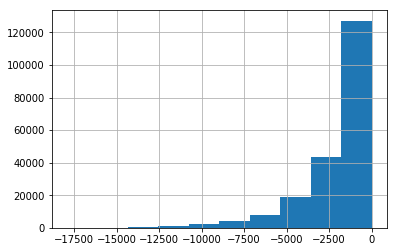

In [44]:
train[train['DAYS_EMPLOYED'] == 365243] = 0

train['DAYS_EMPLOYED'].hist()

In [5]:
def clip(df):
    # all people with more than 4 children are cliped to 4
    df['CNT_CHILDREN'].clip(lower=0, upper=4, inplace=True)
    
    # all people with more than 6 fam. members are cliped to 6
    df['CNT_FAM_MEMBERS'].clip(lower=0, upper=6, inplace=True) 
    
    df['AMT_REQ_CREDIT_BUREAU_HOUR'].clip(lower=0, upper=2, inplace=True)
    df['AMT_REQ_CREDIT_BUREAU_DAY'].clip(lower=0, upper=2, inplace=True)
    df['AMT_REQ_CREDIT_BUREAU_WEEK'].clip(lower=0, upper=2, inplace=True)
    df['AMT_REQ_CREDIT_BUREAU_MON'].clip(lower=0, upper=10, inplace=True)
    df['AMT_REQ_CREDIT_BUREAU_QRT'].clip(lower=0, upper=6, inplace=True)
    df['AMT_REQ_CREDIT_BUREAU_YEAR'].clip(lower=0, upper=6, inplace=True)
    df['OBS_30_CNT_SOCIAL_CIRCLE'].clip(lower=0, upper=17, inplace=True)
    df['OBS_60_CNT_SOCIAL_CIRCLE'].clip(lower=0, upper=17, inplace=True)
    df['DEF_30_CNT_SOCIAL_CIRCLE'].clip(lower=0, upper=5, inplace=True)
    df['DEF_60_CNT_SOCIAL_CIRCLE'].clip(lower=0, upper=4, inplace=True)
    
    df['CNT_ACTIVE_LOANS'].clip(lower=0, upper=15, inplace=True)
    
    
    
    # lumping rare income types into a single category
    index1 = df[df['NAME_INCOME_TYPE'] == 'Businessman'].index
    index2 = df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index
    index3 = df[df['NAME_INCOME_TYPE'] == 'Student'].index
    index4 = df[df['NAME_INCOME_TYPE'] == 'Unemployed'].index
    
    df.loc[index1,'NAME_INCOME_TYPE'] = 'OTHER'
    df.loc[index2,'NAME_INCOME_TYPE'] = 'OTHER'
    df.loc[index3,'NAME_INCOME_TYPE'] = 'OTHER'
    df.loc[index4,'NAME_INCOME_TYPE'] = 'OTHER'
    
def quantize(df, bins=10):
    features_to_quantazie = [
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'AMT_GOODS_PRICE',
        'DAYS_BIRTH',
        'DAYS_ID_PUBLISH',
        'DAYS_LAST_PHONE_CHANGE',
        'DAYS_REGISTRATION',
        'OWN_CAR_AGE',
        'REGION_POPULATION_RELATIVE'
    ]
    
    for feature in features_to_quantazie:
        if feature != 'DAYS_LAST_PHONE_CHANGE':
            df[feature] = pd.qcut(df[feature], bins, labels=False)
        else:
            df[feature] = pd.qcut(df[feature], bins-2, labels=False)
            
    for feature in features_to_quantazie:
        df[feature] = df[feature].astype('category')

In [ ]:
quantize(df)          # 5
clip(df)              # 6

In [ ]:
train.to_csv('../input/train.csv', index=True)
valid.to_csv('../input/valid.csv', index=True)
infer_csv.to_csv('../input/infer.csv', index=True)

After PCA I have identified the following features: Note these 10 features explain 95%+ from the variance in the dataset
* AMT_CREDIT
* AMT_GOODS_PRICE
* AMT_ACTIVE_LOANS
* AMT_OUTSTD_0_YEAR
* AMT_OUTSTD_1_YEAR
* AMT_OUTSTD_2_YEAR
* AMT_OUTSTD_3_YEAR
* AMT_OUTSTD_4_YEAR
* AMT_OUTSTD_5_YEAR
* DAYS_EMPLOYED